In [35]:
!pip install matplotlib
from matplotlib import pyplot as plt
import math

  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 14.5 MB/s eta 0:00:00 MB/s eta 0:00:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 23.0 MB/s eta 0:00:0031m24.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 19.1 MB/s eta 0:00:0031m19.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 19.2 MB/s eta 0:00:0031m20.1 MB/s eta 0:00:01
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)


# Analisys for the WATTIMETER

This is a ESP32 project aimed to provide power consumption information for the network. 

The project will use:
* ESP32
* ACS712

## For the current sensing - ACS712
The project will use the ACS712 current sensor to be able to measure the current.
The ACS712 has very specific voltage-current graph as show bellow:
![acs712](current_sensor.png)

Since the 0A is exactly at 2.5V for the output, we will need to adjust our code. I have no intention of moving this values to increase resolution, the reason behind it is to minimise components in the circuitry.

The equation for the current is:
$$
A = \frac{(A_1 + A_2 + A_3 + ... + A_n)}{A_n}
$$

For the Arms the equation is:
$$
A_{rms} = \sqrt{\frac{A_1^2 + A_2^2 + A_3^2 + ... + A_n^2}{n}}
$$

For the ADC in the ESP32 we need to be able to read the actual current value, so we know that:
* ESP32 adc has 3.3v
* 12bit adc 4095

This means we have better resolution setting up oue sensor to read negative current, from 0A to -30A

The equation for the datasheet graph is:
$$
V = A*0.1 + 2.5
$$

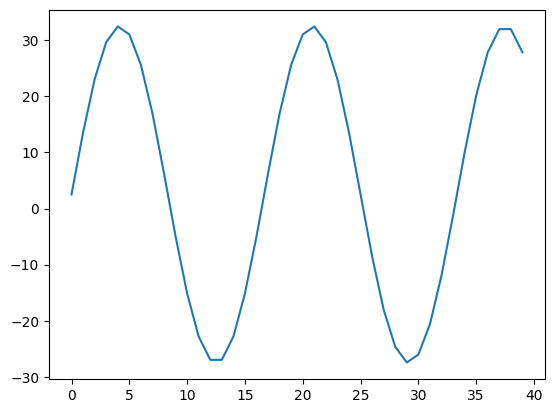

In [46]:
v = []
f = 60
t = 1/f

for n in range(0,40,1):
    v.append(30*math.sin(n/1000*2*math.pi*f)+2.5)
plt.plot(v)